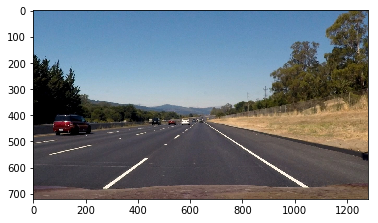

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from glob import glob


#######################################################################
test_images_paths = glob('/home/andrej/git/CarND-P4-Advanced-Lane-Finding/test_images/*.jpg')

image = cv2.imread('/home/andrej/git/CarND-P4-Advanced-Lane-Finding/test_images/straight_lines2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()


In [16]:
camera_matrix = [[1.15777930e+03, 0.00000000e+00, 6.67111054e+02],
 [0.00000000e+00, 1.15282291e+03, 3.86128937e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]

dist_coeffs = [[-0.24688775, -0.02373134, -0.00109842, 0.00035108, -0.00258569]]

# Warping perspective
def perspective_warp():
    width = 1280
    height = 720
    top_left =[594, 450] # [520, 500] # [7/16*width, 6/10*height]
    top_right = [687, 450]#[768, 500] # [9/16*width, 6/10*height]
    bottom_left = [262, 670] # [1/16*width, 9/10*height]
    bottom_right = [1044, 670] #[15/16*width, 9/10*height]
    src_points = np.float32([top_left, top_right, bottom_left, bottom_right])
    dst_points = np.float32([
        [4/16*width, 0/10*height], # top left
        [12/16*width, 0/10*height], # top right
        [4/16*width, 10/10*height], # bottom left
        [12/16*width, 10/10*height]  # bottom right
    ])
    warp_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    unwarp_matrix = cv2.getPerspectiveTransform(dst_points, src_points)
    return warp_matrix, unwarp_matrix


def warp_image(image, warp_matrix):
    width = image.shape[1]
    height = image.shape[0]
    warped_image = cv2.warpPerspective(image, warp_matrix, (width, height))
    return warped_image

#######################################################################
warp_matrix, unwarp_matrix = perspective_warp()
print ('Warp:',warp_matrix)
print('Unwarp:', unwarp_matrix)

Warp: [[ -4.86204634e-01  -1.49507925e+00   9.38982700e+02]
 [ -5.88418203e-15  -1.94426603e+00   8.74919714e+02]
 [ -8.89045781e-18  -2.37922580e-03   1.00000000e+00]]
Unwarp: [[  1.45312500e-01  -7.81724211e-01   5.47500000e+02]
 [ -3.55271368e-15  -5.14332907e-01   4.50000000e+02]
 [ -8.23993651e-18  -1.22371412e-03   1.00000000e+00]]


Left points (top/bottom): (320, 0) (320, 720)
Right points (top/bottom): (960, 0) (960, 720)
Lane width: 640 px


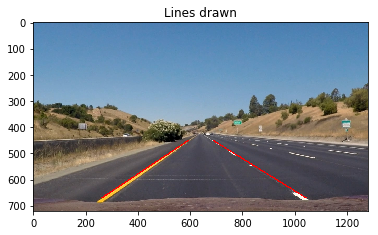

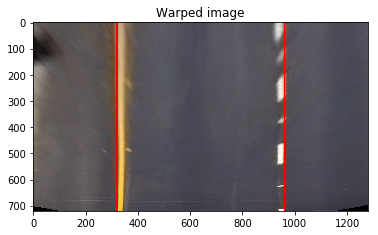

In [8]:
def showImage(image, title='Photo'):
    plt.imshow(image)
    plt.title(title)
    plt.show()
    

def showGrayImage(image, title='Photo'):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()
    

def showChannels(image):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    for c, ax in zip(range(3), axs):
        tmp_img = np.zeros(image.shape, dtype="uint8")
        tmp_img[:,:,c] = image[:,:,c]
        tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_RGB2GRAY)
        ax.imshow(tmp_img, cmap='gray')
        ax.set_axis_off()
    plt.show()


#######################################################################
X_images = []

for image_path in test_images_paths:
    image = plt.imread(image_path)
    #print(image.shape)
    X_images.append(image)
    
X_images = np.array(X_images)
#print(X_images.shape)

top_left =(594, 450) # [520, 500] # [7/16*width, 6/10*height]
top_right = (687, 450)#[768, 500] # [9/16*width, 6/10*height]
bottom_left = (262, 670) # [1/16*width, 9/10*height]
bottom_right = (1044, 670) #[15/16*width, 9/10*height]

width = X_images[0].shape[1]
height = X_images[0].shape[0]
top_left_warped = (int(4/16*width), int(0/10*height)) # top left
top_right_warped = (int(12/16*width), int(0/10*height)) # top right
bottom_left_warped = (int(4/16*width), int(10/10*height))# bottom left
bottom_right_warped = (int(12/16*width), int(10/10*height))# bottom right

print('Left points (top/bottom):', top_left_warped, bottom_left_warped)
print('Right points (top/bottom):', top_right_warped, bottom_right_warped)
print('Lane width:', abs(bottom_left_warped[0] - bottom_right_warped[0]), 'px')

lines_image = np.copy(X_images[1])
warped_image = np.copy(warp_image(lines_image, warp_matrix))

lines_image = cv2.line(lines_image, top_left, bottom_left, (255,0,0), 3)
lines_image = cv2.line(lines_image, top_right, bottom_right, (255,0,0), 3)
warped_image = cv2.line(warped_image, top_left_warped, bottom_left_warped, (255,0,0), 3)
warped_image = cv2.line(warped_image, top_right_warped, bottom_right_warped, (255,0,0), 3)

showImage(lines_image, 'Lines drawn')
showImage(warped_image, 'Warped image')

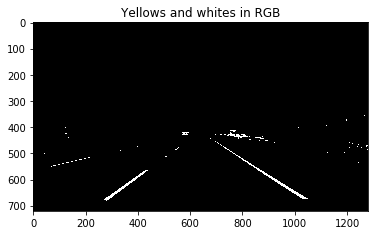

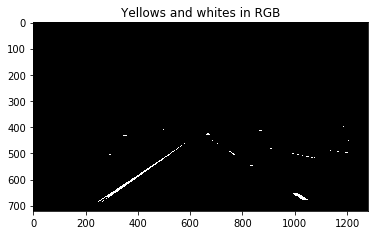

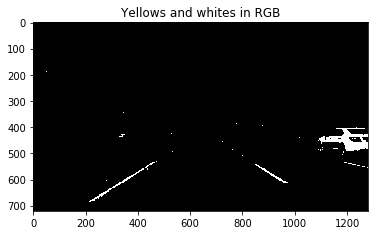

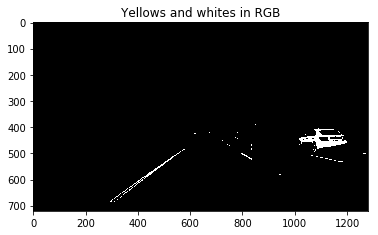

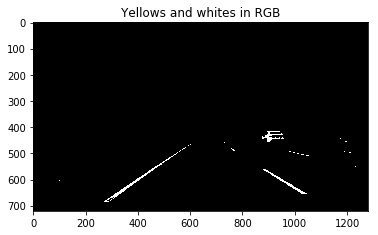

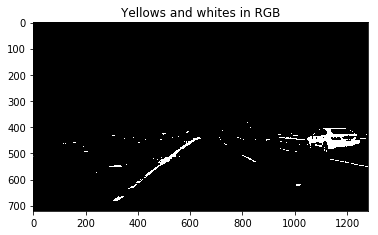

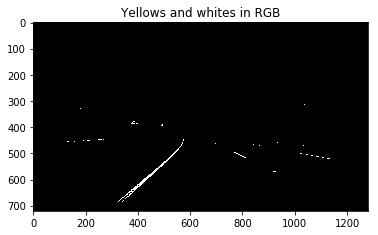

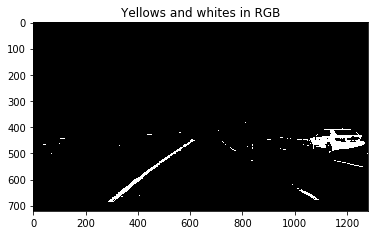

In [9]:
# White lane lines extraction
def white_lines_RGB(image):
    color_select_img = np.copy(image)
    red_threshold = 200
    green_threshold = 185
    blue_threshold = 199

    # Identify pixels below the threshold. Black 'em out
    colour_thresholds = (image[:,:,0] < red_threshold) | \
                 (image[:,:,1] < green_threshold) | \
                 (image[:,:,2] < blue_threshold)
    color_select_img[colour_thresholds] = [0,0,0]
    color_select_img = cv2.cvtColor(color_select_img, cv2.COLOR_RGB2GRAY)
    slice = color_select_img[:,:] > 0
    color_select_img[slice] = 255
    return color_select_img


# Yellow lane lines extraction
def yellow_lines_RGB(image):
    color_select_img = np.copy(image)
    red_threshold = 220
    green_threshold = 180
    blue_threshold = 40
    #rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Identify pixels below the threshold. Black 'em out
    colour_thresholds = (image[:,:,0] < red_threshold) | \
                 (image[:,:,1] < green_threshold) | \
                 (image[:,:,2] < blue_threshold)
    color_select_img[colour_thresholds] = [0,0,0]
    color_select_img = cv2.cvtColor(color_select_img, cv2.COLOR_RGB2GRAY)
    slice = color_select_img[:,:] > 0
    color_select_img[slice] = 255
    return color_select_img


#######################################################################
#for img in test_images:
#    showChannels(cv2.cvtColor(plt.imread(img), cv2.COLOR_RGB2HLS))
    
#print('RGB mode:')
#for img in test_images:
#    showChannels(plt.imread(img))

for img in X_images:
    image = yellow_lines_RGB(img)
    showGrayImage(image, 'Yellows and whites in RGB')


In [10]:
def sobel(gray, direction):
    if direction == 'x': # Sobel X
        return cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        return cv2.Sobel(gray, cv2.CV_64F, 0, 1)


# From the Udacity Advanced Lane Finding lectures
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sobel_binary


# Define a function that applies Sobel x and y,
# then computes the magnitude of the gradient
# and applies a threshold
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    magnitude_sobel = np.sqrt((sobelx * sobelx + sobely * sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * magnitude_sobel / np.max(magnitude_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sobel_binary


# Define a function that applies Sobel x and y,
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction_grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sobel_binary = np.zeros_like(direction_grad)
    sobel_binary[(direction_grad >= thresh[0]) & (direction_grad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sobel_binary

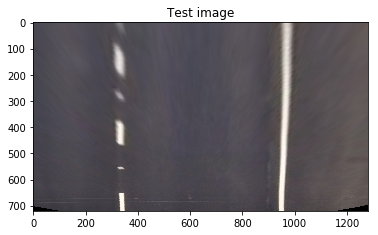

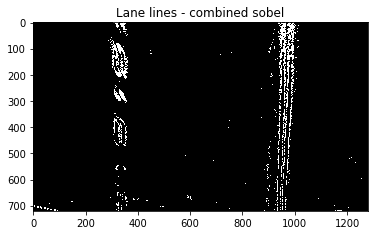

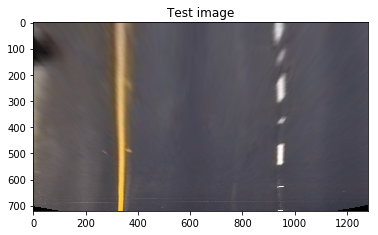

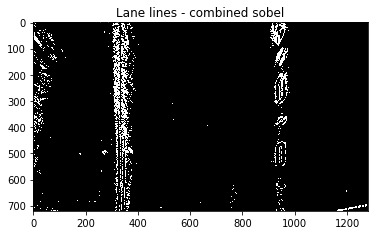

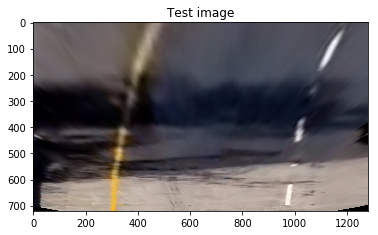

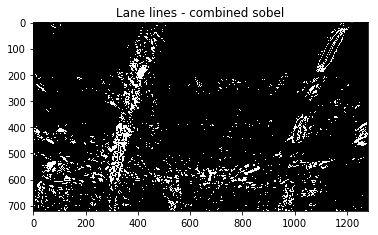

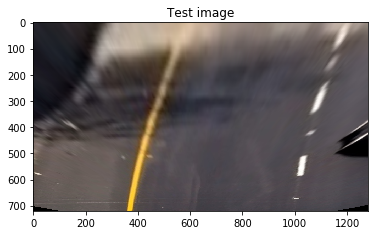

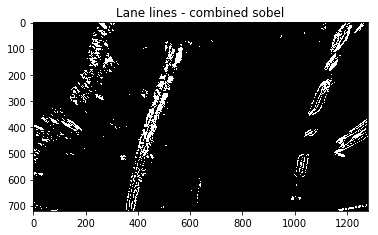

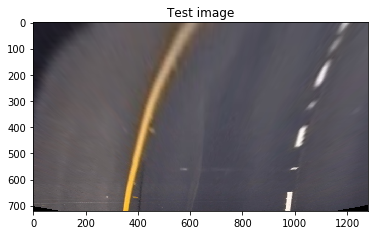

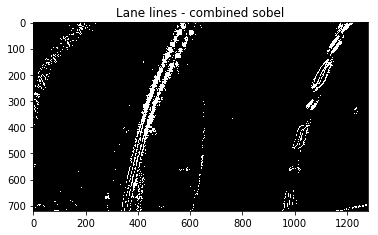

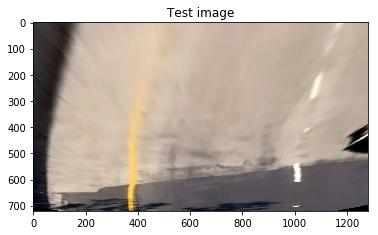

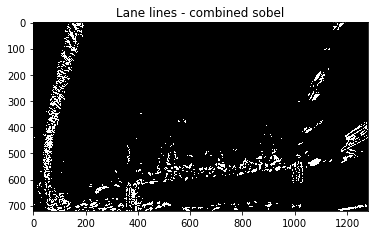

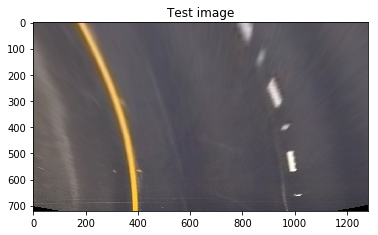

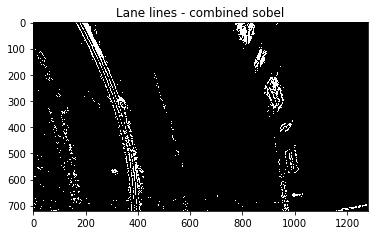

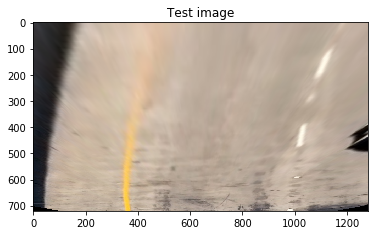

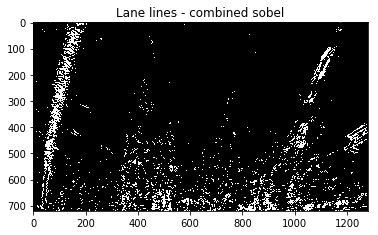

In [11]:
# Color and gradient thresholds 
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary

def sobel_select(img, thresh=(20, 100)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_new = img[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(img_new, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sobel_x_binary = np.zeros_like(scaled_sobel)
    sobel_x_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sobel_x_binary


def find_laneLines_sobel(img, ksize=3, thresh=(0,255), mag_thresh=(0,255), dir_thresh=(0, np.pi/2)):
    # Choose a larger k-size (odd number) to get smoother gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=thresh)
    mag_binary = mag_threshold(img, sobel_kernel=ksize, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=dir_thresh)

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined


#######################################################################
for ind in np.arange(0, len(X_images)):
    test_img = np.copy(X_images[ind])
    test_img = cv2.undistort(test_img, np.array(camera_matrix), np.array(dist_coeffs), None, np.array(camera_matrix))
    #plt.imsave(fname='/home/andrej/git/CarND-P4-Advanced-Lane-Finding/examples/undistorted_' + test_images_paths[ind].split('/')[-1],
    #           arr=test_img, format='jpg')
    test_img = warp_image(test_img, warp_matrix)
    showImage(test_img, 'Test image')
    plt.imsave(fname='/home/andrej/git/CarND-P4-Advanced-Lane-Finding/examples/warped_' + test_images_paths[ind].split('/')[-1],
               arr=test_img, format='jpg')
    test_img = cv2.blur(test_img, (9,9))
    
    final = cv2.add(find_laneLines_sobel(
            test_img, ksize=3, 
            thresh=(15, 90), 
            mag_thresh=(10, 90), 
            dir_thresh=(0.8, 1.)
            ),
        find_laneLines_sobel(
            test_img, ksize=3, 
            thresh=(15, 90), 
            mag_thresh=(10, 90), 
            dir_thresh=(0.01, 0.2)
            )
    )
    final[final>0] = 255
    #final[:,final.shape[1]-100:final.shape[1]] = 0
    #final[:,:200] = 0
    #final[500:final.shape[0], 450:900] = 0
    showGrayImage(
        final, 
        'Lane lines - combined sobel'
    )


In [ ]:
# Pipeline for image processing
def pipeline(image):
    image = cv2.undistort(image, np.array(camera_matrix), np.array(dist_coeffs), None, np.array(camera_matrix))
    image = warp_image(image, warp_matrix)
    
    color_mask = cv2.add(yellow_lines_RGB(image), white_lines_RGB(image))
    color_mask[color_mask>0] = 255
    
    sobel_mask = cv2.add(
        find_laneLines_sobel(
            cv2.blur(image, (9,9)), ksize=3, 
            thresh=(15, 90), 
            mag_thresh=(10, 90), 
            dir_thresh=(0.8, 1.)
            ),
        find_laneLines_sobel(
            cv2.blur(image, (9,9)), ksize=3, 
            thresh=(15, 90), 
            mag_thresh=(10, 90), 
            dir_thresh=(0.01, 0.2)
            )
    )
    sobel_mask[sobel_mask>0] = 255
    # Eliminate noise
    kernel = np.ones((3,3),np.uint8)
    sobel_mask = cv2.erode(sobel_mask,kernel,iterations = 1)
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_OPEN, kernel)

    hls_mask = hls_select(cv2.blur(image, (9,9)), thresh=(115, 255))
    hls_mask[hls_mask>0] = 255
    return np.dstack((color_mask, hls_mask, sobel_mask))*255


#######################################################################
# Testing the pipeline
for ind in np.arange(0, len(test_images_paths)):
    result = pipeline(X_images[ind])
    showImage(result, 'Processed image')
    #plt.imsave(fname='/home/andrej/git/CarND-P4-Advanced-Lane-Finding/examples/lane_lines_mask_' + test_images_paths[ind].split('/')[-1],
    #           arr=result, format='jpg')


left line: [  3.85431939e-05  -1.70072473e-02   3.32913402e+02]
right line: [ -3.57497294e-05  -8.64126824e-03   9.70527354e+02]
diff: [  7.42929233e-05  -8.36597910e-03  -6.37613952e+02]


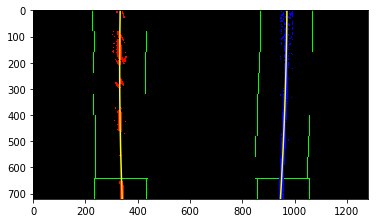

3895.79935167 m 4200.47334253 m


left line: [ -6.31198900e-05   6.86610744e-02   3.19869705e+02]
right line: [ -8.90959950e-05   6.58421070e-02   9.36025510e+02]
diff: [  2.59761050e-05   2.81896735e-03  -6.16155804e+02]


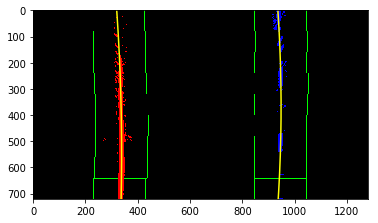

2378.84237294 m 1685.45137843 m


left line: [  5.74052494e-04  -7.10868343e-01   5.27420943e+02]
right line: [ -8.91017783e-06   4.32285040e-02   9.60411999e+02]
diff: [  5.82962672e-04  -7.54096847e-01  -4.32991056e+02]


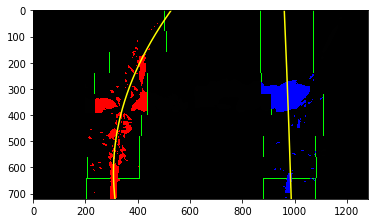

261.660943789 m 16851.9825606 m


left line: [  2.26900214e-04  -4.97181776e-01   6.07121714e+02]
right line: [  1.68635342e-04  -4.05606827e-01   1.19801318e+03]
diff: [  5.82648722e-05  -9.15749488e-02  -5.90891467e+02]


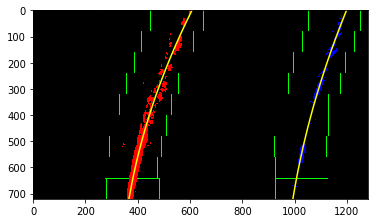

662.303499775 m 891.067787516 m


left line: [  2.60320838e-04  -5.07806552e-01   5.87604071e+02]
right line: [  2.78712163e-04  -5.10847693e-01   1.19504682e+03]
diff: [ -1.83913246e-05   3.04114084e-03  -6.07442746e+02]


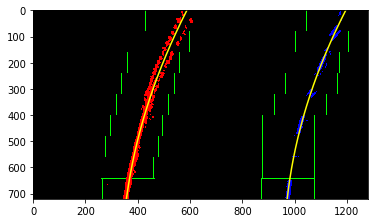

577.08554384 m 538.916828356 m


left line: [  9.71583434e-05  -1.74418838e-01   4.45154597e+02]
right line: [  2.31768707e-04  -4.19523755e-01   1.17182868e+03]
diff: [ -1.34610364e-04   2.45104917e-01  -7.26674080e+02]


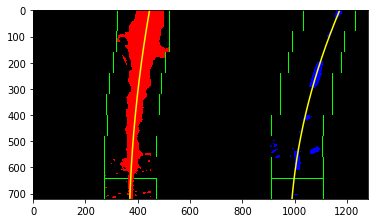

1545.47069646 m 647.983937934 m


left line: [ -3.62987371e-04   5.46427982e-01   1.86193969e+02]
right line: [ -4.02085798e-04   5.76093723e-01   7.95795681e+02]
diff: [  3.90984274e-05  -2.96657416e-02  -6.09601712e+02]


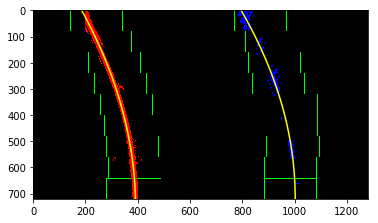

413.658311073 m 373.428184053 m


left line: [  2.66679088e-05  -1.38457394e-01   4.33930455e+02]
right line: [  6.15243398e-04  -6.70749758e-01   1.20053804e+03]
diff: [ -5.88575489e-04   5.32292364e-01  -7.66607582e+02]


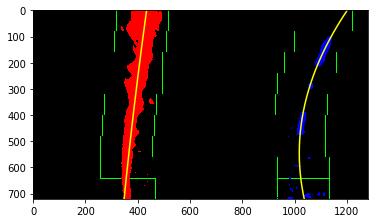

5631.99790126 m 244.37272765 m


In [14]:
# Find the lines
def mask(image):
    image = cv2.undistort(image, np.array(camera_matrix), np.array(dist_coeffs), None, np.array(camera_matrix))
    image = warp_image(image, warp_matrix)
    color_mask = cv2.add(yellow_lines_RGB(image), white_lines_RGB(image))
    color_mask[color_mask > 0] = 255
    #color_mask = np.array(color_mask, dtype=np.int8)
    #showGrayImage(color_mask, 'Color mask')
    sobel_mask = cv2.add(
        find_laneLines_sobel(
            cv2.blur(image, (9,9)), ksize=3, 
            thresh=(15, 90), 
            mag_thresh=(10, 90), 
            dir_thresh=(0.8, 1.)
            ),
        find_laneLines_sobel(
            cv2.blur(image, (9,9)), ksize=3, 
            thresh=(15, 90), 
            mag_thresh=(10, 90), 
            dir_thresh=(0.01, 0.2)
            )
    )
    sobel_mask[sobel_mask>0] = 255
    
    kernel = np.ones((3,3),np.uint8)
    sobel_mask = cv2.erode(sobel_mask,kernel,iterations = 1)
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_OPEN, kernel)
    #sobel_mask = np.array(sobel_mask, dtype=np.int8)
    #showGrayImage(sobel_mask, 'Sobel mask')
    hls_mask = hls_select(cv2.blur(image, (9,9)), thresh=(115, 255))
    hls_mask[hls_mask>0] = 255
    #hls_mask = np.array(hls_mask, dtype=np.int8)
    #showGrayImage(hls_mask, 'HLS_mask')
    result_mask = np.zeros_like(hls_mask)
    result_mask[sobel_mask > 0] = 255
    result_mask[hls_mask > 0] = 255
    result_mask[color_mask > 0] = 255
    result_mask[:,result_mask.shape[1]-100:result_mask.shape[1]] = 0
    result_mask[:,:200] = 0
    result_mask[500:result_mask.shape[0], 450:900] = 0
    return result_mask


def line_detect(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    print('left line:', left_fit)
    print('right line:', right_fit)
    print('diff:', left_fit-right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    #plt.imsave(fname='/home/andrej/git/CarND-P4-Advanced-Lane-Finding/examples/lane_detection_' + test_images_paths[ind].split('/')[-1],
    #           arr=out_img, format='jpg')
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30./720. # meters per pixel in y dimension
    xm_per_pix = 3.7/640. # meters per pixel in x dimension
    
    # See if the curvatures align now!
    # Udacity code here, adapted to fit the project's needs
    # Define conversions in x and y from pixels space to meters
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
#######################################################################
# Testing the pipeline
X_masks = []
for ind in np.arange(0, len(test_images_paths)):
    result_mask = mask(X_images[ind])
    X_masks.append(result_mask)
    line_detect(result_mask)
    
X_masks = np.array(X_masks)

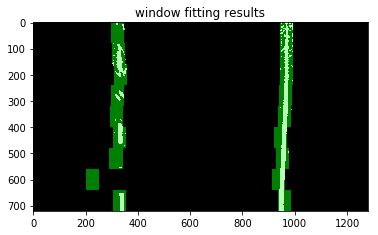

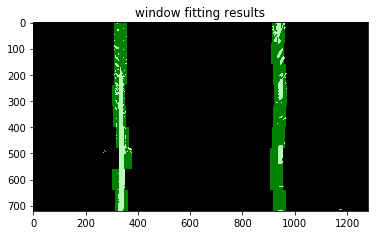

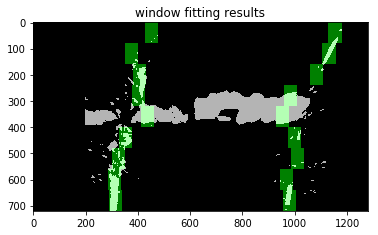

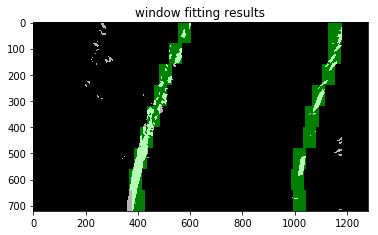

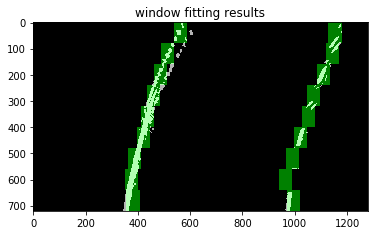

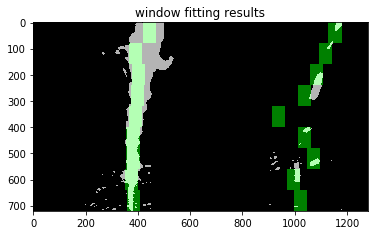

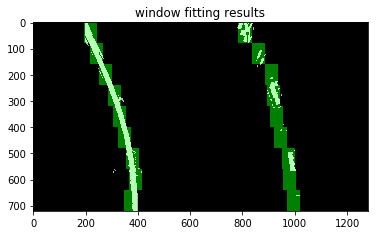

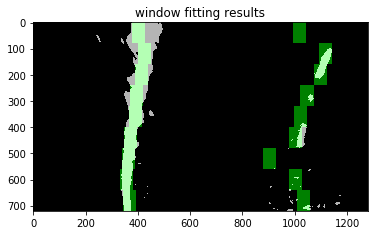

In [15]:
# Using convolutions
import matplotlib.image as mpimg


def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output


def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/8):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/8):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


#######################################################################
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

# Read in a thresholded image
for ind in range(len(X_masks)):
    warped = np.copy(X_masks[ind])
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    
    # If we found any window centers
    if len(window_centroids) > 0:
    
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
    
        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
    
        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
     
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    # Display the final results
    warped = cv2.merge((warped, warped, warped))
    output = cv2.addWeighted(output, 1.0, warped, 0.7, 0.0)
    
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    #plt.imsave(fname='/home/andrej/git/CarND-P4-Advanced-Lane-Finding/examples/lane_lines_convolved_' + test_images_paths[ind].split('/')[-1],
    #           arr=output, format='jpg')
